# Info

Setting up the model to recreate the oscillating basin from the non-hydrostatic manual <br>
[Link to the manual](https://oss.deltares.nl/documents/4142077/4199062/non-hydrostatic_report_draft.pdf/eadc1aff-6e19-6e82-2747-3c11c30457ee?t=1624871720408)


Testing the updated xBeach toolbox to see if it can create the non-hydrostatic model

In [1]:
# import default modules
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from matplotlib import cm
import sys
import os
import subprocess

# Set global constants
PI = np.pi

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(r"C:\ERDC\xbeach-toolbox")

**no xbTools installation found in environment, adding parent path of notebook to see if it works


In [2]:
## import xbeach tools
#sys.path.append(os.path.abspath(os.path.join('..' )))

from xbTools.grid.creation import xgrid, ygrid
from xbTools.grid.extension import seaward_extend
from xbTools.xbeachtools import XBeachModelSetup
from xbTools.general.wave_functions import offshore_depth
from xbTools.xbeachpost import XBeachModelAnalysis
from xbTools.general.executing_runs import generate_batch_script
from xbTools.general.executing_runs import (generate_batch_script, 
                                            run_batch_script)

In [3]:
def create_directory_if_not_exists(directory_path):
    """
    Creates a directory if it does not already exist.
    
    Parameters:
    directory_path (str): The path of the directory to create.
    """
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
    else:
        print(f"Directory '{directory_path}' already exists.")

def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path

### Import library functions

In [4]:
sys.path.append(r"C:\ERDC\tutorial_models")

from lib.solitary_funcs import (calc_L_scaling, calc_wave_speed, calc_surface_elevation,
                                calc_u_vel, calc_v_vel, calc_depth_average_u, calc_Smit_L_scaling)


### Define the model parameters

### Setup the model directories

In [5]:
# Define paramters for analytical solution
wave_height = 1.0
epsilon = 0.1
g  = 9.81
d0 = wave_height/epsilon

In [6]:
# Get the folder of the current script
script_dir = get_script_directory()

# Generate the model directory
model_dir = os.path.join(script_dir, "")

create_directory_if_not_exists(model_dir)

exe_path = r"C:\ERDC\tutorial_models\XBeach_1.24.6057_Halloween_win64_netcdf\xbeach.exe"

# Make the batch file in the model dir
generate_batch_script(model_dir, exe_path, batch_file_name = "run_model.bat", 
                      include_cd = False, batch_file_folder = None)


batch_file_path = os.path.join(model_dir, "run_model.bat")

print("Script directory is: {}".format(script_dir))

Directory 'c:\ERDC\tutorial_models\solitary_wave_Smit\6_solitary_wave_no_zsinit_2_layer_no_breaker\' already exists.
Script directory is: c:\ERDC\tutorial_models\solitary_wave_Smit\6_solitary_wave_no_zsinit_2_layer_no_breaker


### Calc the analytical solution

In [7]:
# Model parameters
# The model domain length and simulation time also change with the incident wave height

L_sol = calc_L_scaling(epsilon, delta_scaling=1/20) # Length of the solitary wave
# L_sol = calc_Smit_L_scaling(epsilon * d0, d0, delta = 1/20) # Length of the solitary wave

# Scaling to match Smit number (Not sure where he got his number)
L_sol = 10 * L_sol

num_wave_lengths = 14.0
model_length = num_wave_lengths * L_sol            # Length of the domain
x0 = -2 * L_sol                                     # Initial x-offset

num_points_per_wavelength = 200
nx = int(num_wave_lengths * num_points_per_wavelength)

# Model domain values
x = np.linspace(0, model_length, nx +1)

c = calc_wave_speed(g, epsilon, d0)

# Define model parameters
model_time = model_length/c

# Setting the analytical solution time higher than the model time to see if the jump goes away
num_analy_times = 1000

CFL = 0.2

print("Scaling wave lengths: {}".format(L_sol))
print("Channel Lengths: {}".format(model_length))
print("x0 Locations: {}".format(x0))
print("Number of points: {}".format(nx))
print("Wave speed: {}".format(c))

Scaling wave lengths: 79.53925506456179
Channel Lengths: 1113.549570903865
x0 Locations: -159.07851012912357
Number of points: 2800
Wave speed: 10.38544541608426


In [8]:
# Set the index for the current wave
index = 0

# Select the time arr
time = np.linspace(0, model_time+20, num_analy_times)

x_location = 0.0
# Calc the x velocity
u_vel = calc_u_vel(epsilon, x0 = x0, x = x_location, y = d0, t = time, g = g, d0 = d0)

# Calc the y velocity
v_vel = calc_v_vel(epsilon, x0 = x0, x = x_location, y = d0, t = time, g = g, d0 = d0)

# Calc the water surface elevation
eta = calc_surface_elevation(epsilon, x0, x= x_location, t = time, g = g, d0 = d0)

# Calc the average u velocity
u_avg = calc_depth_average_u(epsilon, x0, x = x_location, t = time, g = g, d0 = d0)


# Calc the initial water surface elevation over th domain
init_surface_elev = calc_surface_elevation(epsilon, x0, x, 0, g, d0)

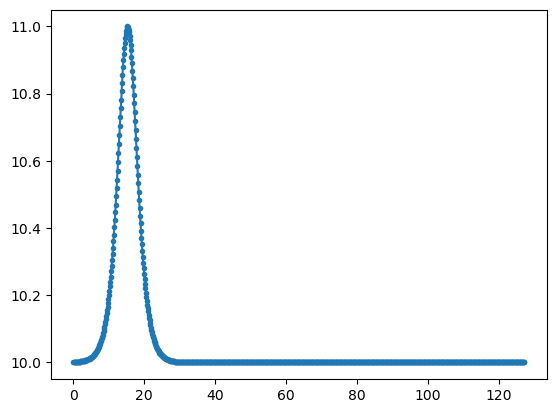

In [12]:
plt.plot(time, eta, marker = ".")

Text(0, 0.5, 'Surface Elevation (m)')

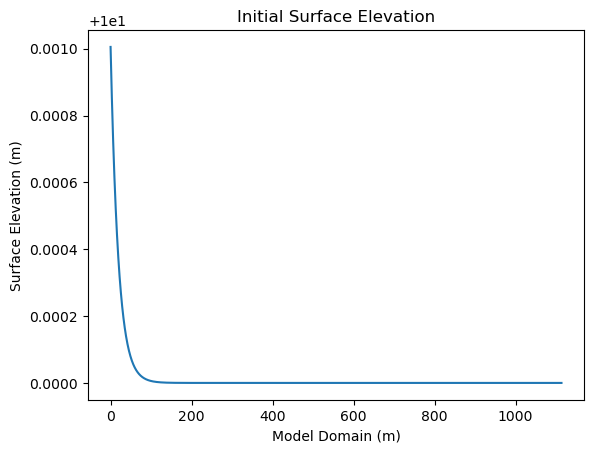

In [32]:
plt.plot(x, init_surface_elev)
plt.title("Initial Surface Elevation")
plt.xlabel("Model Domain (m)")
plt.ylabel("Surface Elevation (m)")

In [33]:
# Calc an average V-Velocity to facilate testing

# Init variable to hold the average
v_avg = 0

# Set a tolerance for how much the velocity changes by
num_depths = 100

# Make an array to hold the depths the v-velocity should be calculated at
depths = np.linspace(0, d0, num_depths)

for depth in depths:
    # Calc the v-velocity and sum it
    v_avg += calc_v_vel(epsilon, x0 = x0, x = x_location, 
                        y = depth, t = time, g = g, d0 = d0)

# Average the value
v_avg= v_avg/num_depths

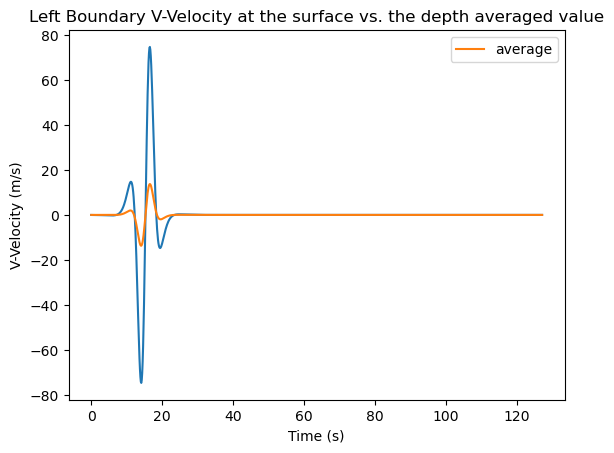

In [34]:
plt.plot(time, v_vel)
plt.plot(time, v_avg, label = "average")

plt.title("Left Boundary V-Velocity at the surface vs. the depth averaged value")
plt.xlabel("Time (s)")
plt.ylabel("V-Velocity (m/s)")
plt.legend()
plt.show()

### Generate the mesh and initial water surface

In [35]:
# Generate the x-mesh
xgr = np.linspace(0, model_length, nx+1)

# Set the y-mesh as none since the model is 1D
ygr = None

# Generate the bathymetry
floor_depth = 0.0
zgr = np.ones(nx + 1) * floor_depth

### Create the model setup
Generating the model setup using the xBeach toolbox

In [36]:
xb_setup = XBeachModelSetup('test')

xb_setup.set_grid(xgr, ygr, zgr, posdwn=-1, alfa=0)
xb_setup.set_nebed(np.ones_like(zgr))
xb_setup.set_friction(np.ones_like(zgr))

In [37]:
# Set the name of the initial water surface elevation
zs_init_filename = "zsinitfile.txt"

# Write the zsinitfile
xb_setup.write_zsinitfile(init_surface_elev, model_dir, file_name = zs_init_filename)

In [38]:
boun_U_dict = {"make_file": True,
               "file_name": "boun_U.bcf",
               "dimension": "vector",
               "variable_dict": {
                   "t" : time,
                   "U" : u_avg, 
                   "W" : v_avg,
                   "zs": eta - d0 # Pertubation from the intial water surface
               }         
}

xb_setup.set_waves('ts_nonh', input_struct=boun_U_dict)


In [39]:
xb_setup.set_params({"wbctype"      : "ts_nonh",
                     'wavemodel'    : 'nonh',
                     'nhbreaker'    : 0,
                     'advection'    : 0,
                     'tideloc'      : 0,
                     'nonh'         : 1,
                     'CFL'          : CFL,
                     'nonhq3d'      : 1,
                     'nhlay'        : 0.33, 
                     'viscosity'    : 0, 
                     'lwave'        : 0, 
                     'bedfriccoef'  : 0.0,
                     'morphology'   : 0,
                    #  'zsinitfile'   : zs_init_filename,
                     'zs0'          : d0,
                     'order'        : 1,
                     'ARC'          : 1, 
                     'front'        : "nonh_1d", 'back'         : "abs_1d" ,
                     'left'         : "neumann", 'right'        : "neumann",

                     'tstop'        : model_time,
                     
                     "tintm"        : 0.1,
                     "tintp"        : 0.1,
                     "tintg"        : 0.1,
                     'nglobalvar'   : ['zs', 'zb', 'H'],
})


The following params were not found in the JSON: 
{'advection': 0, 'nonh': 1}


In [40]:
xb_setup.input_par

{'par': {'advection': 0, 'nonh': 1},
 'Wave boundary condition parameters': {'wbctype': 'ts_nonh'},
 'Physical processes': {'wavemodel': 'nonh',
  'viscosity': 0,
  'lwave': 0,
  'morphology': 0},
 'Non-hydrostatic correction parameters': {'nhbreaker': 0,
  'nonhq3d': 1,
  'nhlay': 0.33},
 'Tide boundary conditions': {'tideloc': 0, 'zs0': 10.0},
 'Model time': {'CFL': 0.2, 'tstop': 107.22212926749165},
 'Flow parameters': {'bedfriccoef': 0.0},
 'Flow boundary condition parameters': {'order': 1,
  'ARC': 1,
  'front': 'nonh_1d',
  'back': 'abs_1d',
  'left': 'neumann',
  'right': 'neumann'},
 'Output': {'tintm': 0.1, 'tintp': 0.1, 'tintg': 0.1},
 '_Output': {'nglobalvar': ['zs', 'zb', 'H']}}

In [41]:
xb_setup.write_model(model_dir, num_dec_dig=10)

Data written to c:\ERDC\tutorial_models\solitary_wave_Smit\6_solitary_wave_no_zsinit_2_layer_no_breaker\boun_U.bcf


### Run and analyze the model

In [42]:
run_batch_script(batch_file_path, flag_print_Blog = False)

Batch file 'c:\ERDC\tutorial_models\solitary_wave_Smit\6_solitary_wave_no_zsinit_2_layer_no_breaker\run_model.bat' executed successfully.


In [43]:
results = XBeachModelAnalysis(fname = "foo", 
                              model_path=model_dir)

In [44]:
results.set_save_fig(False)
results.set_plot_localcoords(False)
results.set_plot_km_coords(False)

loading variable zs from file
loading variable zb from file
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded


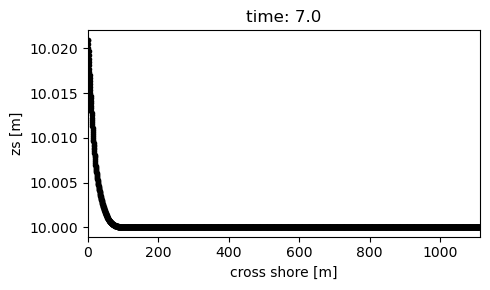

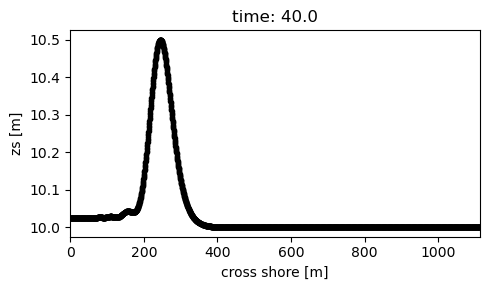

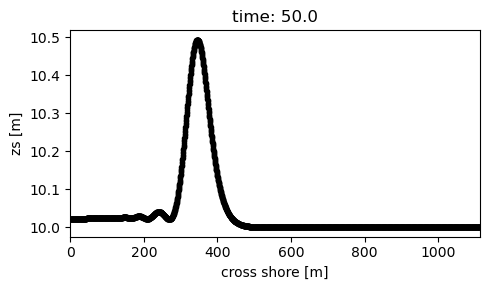

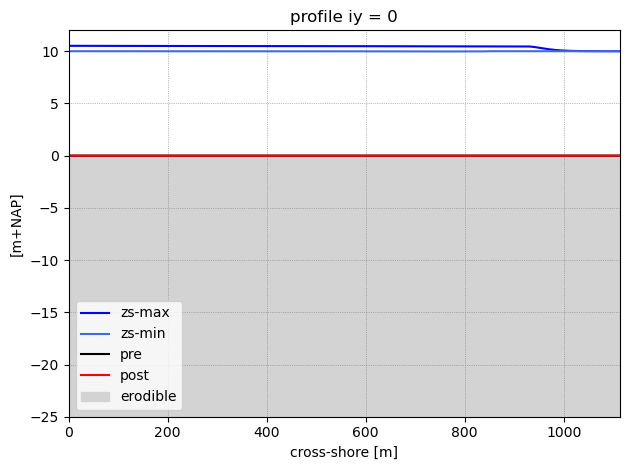

In [45]:
indices = [70, 400, 500]

for index in indices:
    fig, ax = results.fig_cross_var('zs', index, iy=0, coord=None, plot_ref_bathy=False, zmin=-1)

fig, ax = results.fig_profile_change(iy=0)

In [46]:
zs = results.var["zs"]
print(zs.max())

10.517856834219725
